In [1]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math

top_level=f'{os.getcwd()}/../'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import epix_hr_single_10k
import ePixViewer.Cameras as cameras


In [2]:
# Create and start the root class
root = epix_hr_single_10k.RootLCLSIITiming(
    top_level   = top_level,
    sim         = False
)
root.start()

Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)


In [3]:
# Create useful pointers
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = ePixHr10kT.Core.AxiVersion
FwVersion    = 0x3010000
UpTime       = 0:00:15
GitHash      = 0xc063f9c84edb1076b9764a441d508239f92ebd2c
XilinxDnaId  = 0x40020001013a928124b102c5
FwTarget     = EpixHr10kTLclsIITiming
BuildEnv     = Vivado v2022.1
BuildServer  = rdsrv304 (Ubuntu 20.04.5 LTS)
BuildDate    = Wed 31 Aug 2022 05:35:51 PM PDT
Builder      = ddoering
###################################################


In [4]:
#Initialze the camera
#[routine, asic0, asic1, asic2, asic3]'
root.EpixHR.InitASIC([4,0,1,0,0])
#points to the ASIC device under test
ASIC = root.EpixHR.Hr10kTAsic1

Rysync ASIC started
Init ASIC script started
Loading MMCM configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_MMCM_320MHz.yml
Completed
Loading supply configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PowerSupply_Enable.yml
Loading register control (waveforms) configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_RegisterControl_24us_248MHz.yml
Loading packet registers
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PacketRegisters.yml
Taking asic off of reset
Loading ASIC and timing configuration
Loading  /u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PLLBypass_248MHz_ASIC_1.yml
Command executed :  <class 'pyrogue._Command.BaseCommand'> - ePixHr10kT.EpixHR.Hr10kTAsic1.ClearMatrix
Loading Trigger settings
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10

In [12]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)

#sets HSDAC device
root.EpixHR.HSDac.enable.set(True)
#reset status
root.EpixHR.HSDac.WFEnabled.set(False)
root.EpixHR.HSDac.waveformSource.set(0)
root.EpixHR.HSDac.externalUpdateEn.set(False)
root.EpixHR.HSDac.run.set(False)

#configure
dacStart = 0
dacStop = 65535
dacStep = 100
root.EpixHR.HSDac.rCStartValue.set(dacStart)
root.EpixHR.HSDac.rCStopValue.set(dacStop)
root.EpixHR.HSDac.rCStep.set(dacStep)
root.EpixHR.HSDac.WFEnabled.set(True)
root.EpixHR.HSDac.waveformSource.set(1)
root.EpixHR.HSDac.externalUpdateEn.set(True)
root.EpixHR.HSDac.run.set(True)


In [13]:
#use system with batcher and missing ASICs
root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
#Only ASIC 1 is available so disable the 6 lower lanes
root.EpixHR.PacketRegisters0.DisableLane.set(0x3F)
#using internal triggers, so bypassing timing channel at the batcher 
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)

Locked lanes: fc0


In [14]:
#sets ASIC to point to the external DAC
ASIC.mTest.set(True)

In [15]:
# Remove previous dataset
#if os.path.isfile(f'{top_level}/test.dat'):
#    os.remove(f'{top_level}/test.dat')    
#filename = '/u1/ePix10k/data/ExternalDAC/T1_RampTest/ePixHR10kT_V3_externalRamp_320MHz_run1.dat'
filename = '/u2/ddoering/ePixHR10kTLCLSIITiming_ASICV3_externalRamp_320MHz_run1.dat'

In [16]:
if os.path.isfile(f'{filename}'):
    os.remove(f'{filename}')    
    
# Setup and open the file writer
writer = root.dataWriter._writer
writer.open(f'{filename}')

# Wait for the file write to open the file
while( writer.isOpen() is False):
    time.sleep(0.1)

# Wait a little bit for the file to open up
time.sleep(1.0)    
    
#sets TriggerRegisters
AcqCount = root.EpixHR.TriggerRegisters.AcqCount.get()
print("Aquisition Counter " + str(AcqCount))
root.EpixHR.TriggerRegisters.AutoTrigPeriod.set(1000000) #in steps of 10ns
root.EpixHR.TriggerRegisters.AutoRunEn.set(True)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
root.EpixHR.TriggerRegisters.AutoDaqEn.set(True)
root.EpixHR.TriggerRegisters.DaqTriggerEnable.set(True)

# Wait for the file write to write the 10 waveforms
while(writer.getFrameCount() < int(dacStop/dacStep)):
    print( f'Number of frames received: {writer.getFrameCount()}' )
    time.sleep(1)

# stops triggers
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

# Print the status
DeltaAcqCount = root.EpixHR.TriggerRegisters.AcqCount.get() - AcqCount
print( f'Delta Aquisition Counter: {DeltaAcqCount}')
print( f'Number of frames received: {writer.getFrameCount()}' )
        
# Close the file writer
writer.close()

# Wait for the file write to close the file
while( writer.isOpen() is True):
    time.sleep(0.1)

Aquisition Counter 6898
Number of frames received: 0
Number of frames received: 28
Number of frames received: 28
Number of frames received: 28
Number of frames received: 28
Number of frames received: 28


KeyboardInterrupt: 

In [69]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff

def getData(localFile):

    file_header = [0]
    numberOfFrames = 0
    previousSize = 0
    while ((len(file_header)>0) and ((numberOfFrames<MAX_NUMBER_OF_FRAMES_PER_BATCH) or (MAX_NUMBER_OF_FRAMES_PER_BATCH==-1))):
        try:
            # reads file header [the number of bytes to read, EVIO]
            file_header = np.fromfile(localFile, dtype='uint32', count=2)
            payloadSize = int(file_header[0]/2)-2 #-1 is need because size info includes the second word from the header
            newPayload = np.fromfile(f, dtype='uint16', count=payloadSize) #(frame size splited by four to read 32 bit 
            #save only serial data frames
            if (numberOfFrames == 0):
                allFrames = [newPayload.copy()]
            else:
                newFrame  = [newPayload.copy()]
                allFrames = np.append(allFrames, newFrame, axis = 0)
            numberOfFrames = numberOfFrames + 1 
            #print ("Payload" , numberOfFrames, ":",  (newPayload[0:5]))
            previousSize = file_header
       
            if (numberOfFrames%1000==0):
                print("Read %d frames" % numberOfFrames)

        except Exception: 
            e = sys.exc_info()[0]
            #print ("Message\n", e)
            print ('\r', 'numberOfFrames read:', numberOfFrames, 'Size Error, currnt size', file_header, 'previous size', previousSize)
            

    return allFrames

def getDescImaData(localAllFrames):
##################################################
# image descrambling
##################################################
    numberOfFrames = localAllFrames.shape[0]
    currentCam = cameras.Camera(cameraType = cameraType)
    currentCam.bitMask = bitMask
#numberOfFrames = allFrames.shape[0]
    print("numberOfFrames in the 3D array: " ,numberOfFrames)
    print("Starting descrambling images")
    currentRawData = []
    imgDesc = []
    if(numberOfFrames==1):
        [frameComplete, readyForDisplay, rawImgFrame] = currentCam.buildImageFrame(currentRawData = [], newRawData = allFrames[0])
        imgDesc = np.array([currentCam.descrambleImage(bytearray(rawImgFrame.tobytes()))])
    else:
        for i in range(0, numberOfFrames):
        #get an specific frame
            [frameComplete, readyForDisplay, rawImgFrame] = currentCam.buildImageFrame(currentRawData, newRawData = localAllFrames[i,:])
            currentRawData = rawImgFrame

        #get descrambled image from camera
            if (len(imgDesc)==0 and (readyForDisplay)):
                imgDesc = np.array([currentCam.descrambleImage(bytearray(rawImgFrame.tobytes()))])
                currentRawData = []
            else:
                if readyForDisplay:
                    currentRawData = []
                    newImage = np.array([currentCam.descrambleImage(bytearray(rawImgFrame.tobytes()))])
                #newImage = currentCam.descrambleImage(rawImgFrame)
                #newImage = newImage.astype(np.float, copy=False)
                #if (np.sum(np.sum(newImage))==0):
                #    newImage[np.where(newImage==0)]=np.nan
                    imgDesc = np.concatenate((imgDesc, np.array([newImage[0]])),0)

    return imgDesc

In [70]:
f = open(filename, mode = 'rb')
imgDesc = []
for i in range(200):
    print("Starting to get data set %d" % (i))
    allFrames = getData(f)
    imgDesc2 = getDescImaData(allFrames)
    if i == 0:
        headers = allFrames[:,0:6]
        imgDesc = imgDesc2
    else:
        headers = np.concatenate((headers, allFrames[:,0:6]),0)
        imgDesc = np.concatenate((imgDesc, imgDesc2),0)
    if allFrames.shape[0] != MAX_NUMBER_OF_FRAMES_PER_BATCH:
        break


numberOfFrames = allFrames.shape[0]


Starting to get data set 0
 numberOfFrames read: 719 Size Error, currnt size [] previous size [  112196 16777218]
Camera  ePixHr10kTBatcher  selected.
numberOfFrames in the 3D array:  719
Starting descrambling images


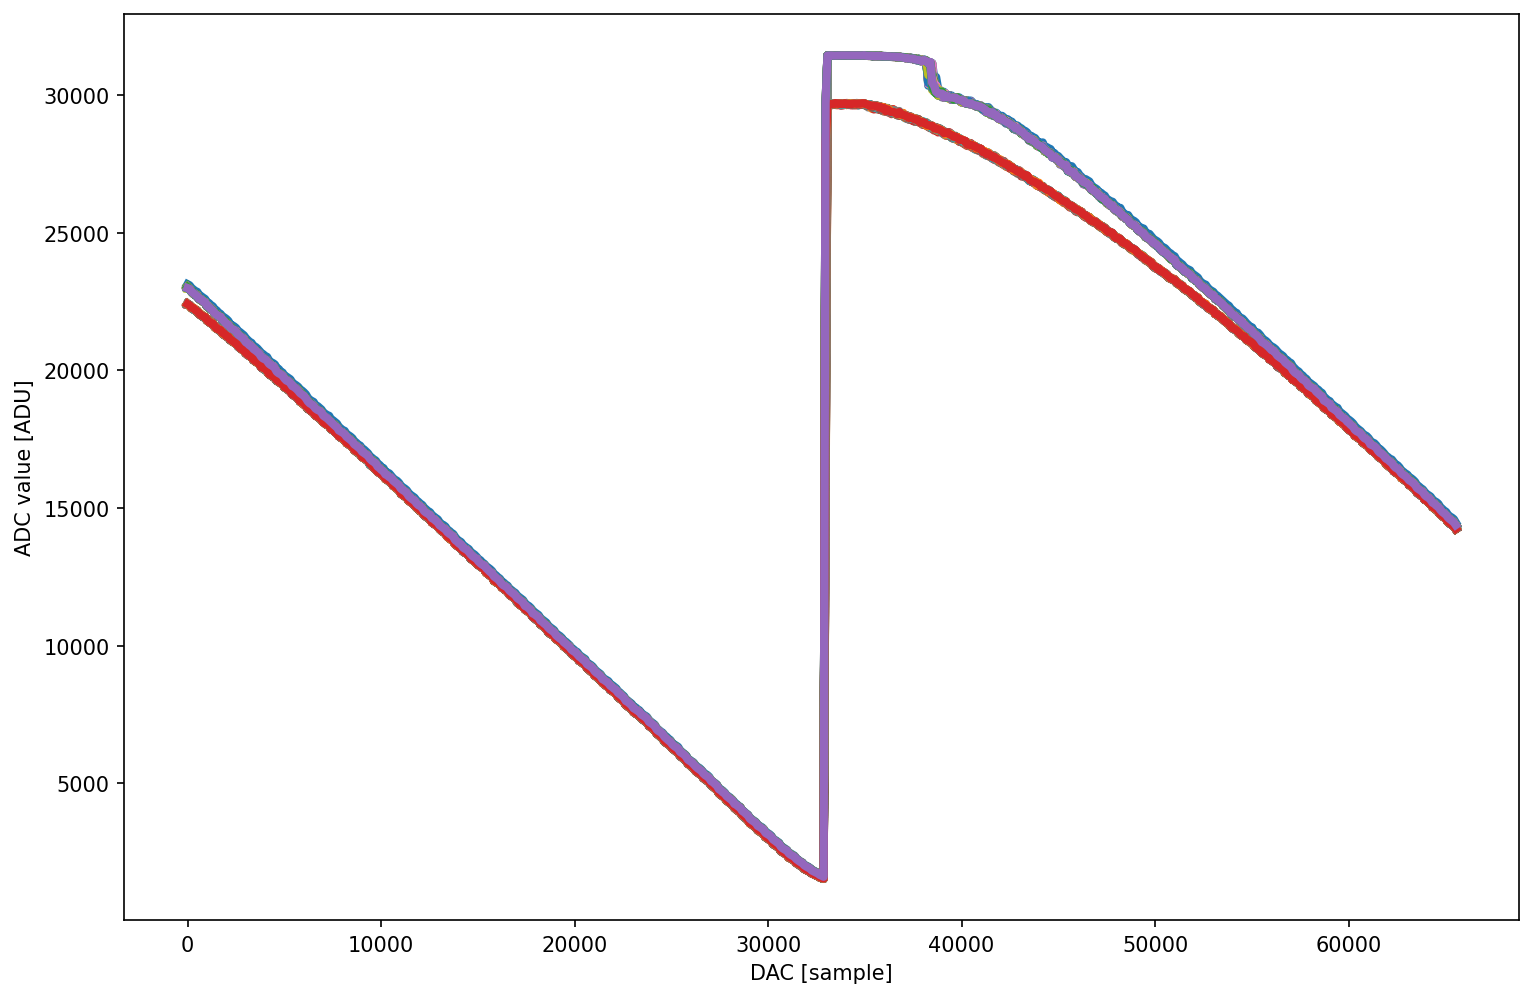

ERROR:pyrogue.PollQueue:Block::checkTransaction: General Error: Transaction error for block ePixHr10kT.EpixHR.SspLowSpeedDecoderReg.LockedCnt[13] with address 0x94010034. Error Timeout waiting for register transaction 5362944 message response.
Traceback (most recent call last):
  File "/afs/slac.stanford.edu/g/reseng/vol31/anaconda/anaconda3/envs/rogue_v5.14.0/lib/python3.9/site-packages/pyrogue/_PollQueue.py", line 169, in _poll
    pr.checkTransaction(entry.block)
  File "/afs/slac.stanford.edu/g/reseng/vol31/anaconda/anaconda3/envs/rogue_v5.14.0/lib/python3.9/site-packages/pyrogue/_Block.py", line 30, in checkTransaction
    block._checkTransaction()
rogue.GeneralError: Block::checkTransaction: General Error: Transaction error for block ePixHr10kT.EpixHR.SspLowSpeedDecoderReg.LockedCnt[13] with address 0x94010034. Error Timeout waiting for register transaction 5362944 message response.
ERROR:pyrogue.PollQueue:Block::checkTransaction: General Error: Transaction error for block ePixHr

In [71]:
plt.figure(1,figsize=(12,8),dpi=150)
for column in np.arange(145):
    plt.plot(np.linspace(dacStart, dacStop, int((dacStop-dacStart)/dacStep)), imgDesc[0:int((dacStop-dacStart)/dacStep),column,10], linewidth=4)
plt.xlabel('DAC [sample]')
plt.ylabel('ADC value [ADU]')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (65535,) and (799,)

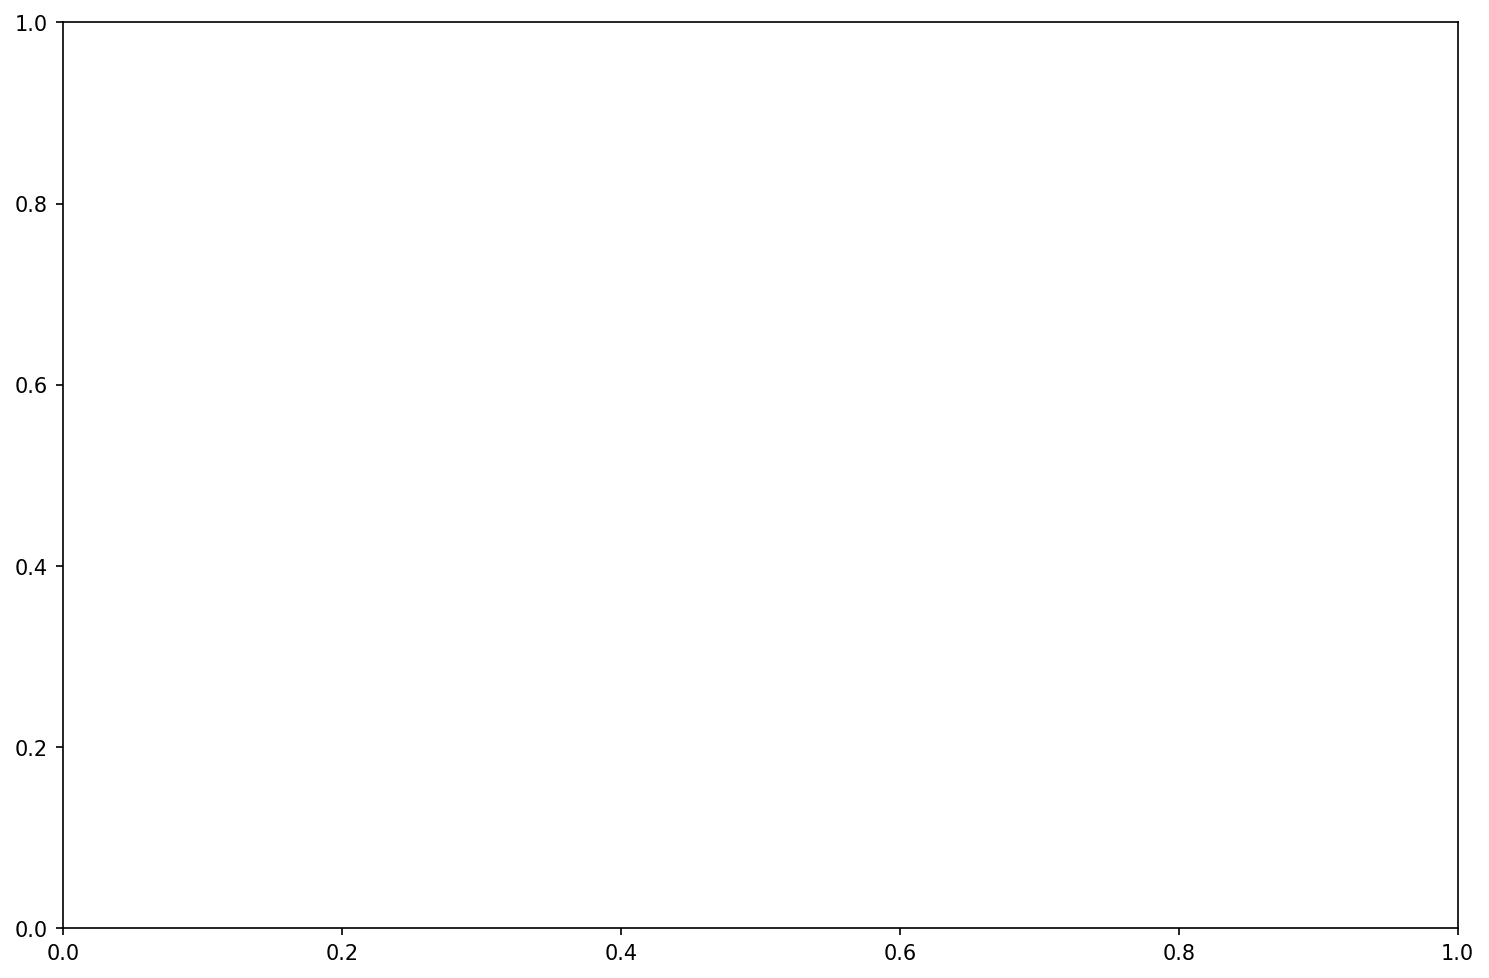

In [41]:
plt.figure(1,figsize=(12,8),dpi=150)
for column in np.arange(146):
    plt.plot(np.linspace(0, 65535, 65535), imgDesc[0:65535,column,10], linewidth=4)
plt.xlabel('DAC [sample]')
plt.ylabel('ADC value [ADU]')
plt.show()

In [ ]:
plt.figure(1,figsize=(12,8),dpi=150)
for column in np.arange(146):
    plt.plot(np.linspace(0, 65535, 65535), imgDesc[0:65535,column,10], linewidth=4)
plt.xlabel('DAC [sample]')
plt.ylabel('ADC value [ADU]')
plt.show()

In [ ]:
CHANNEL_INDEX_CTE = np.arange(10,146,32)
linearStartRange = 4000
linearEndRange = 61000
row = 10
figureIndex = 0
for column in CHANNEL_INDEX_CTE:
    reducedDataSubset = imgDesc[linearStartRange:linearEndRange,column,row]

    #from scipy import signal
    y = np.arange(0,reducedDataSubset.shape[0])#linearStartRange, linearEndRange)[0:65535:11]
    #x = signal.resample(avgdataSubset, 65536)
    x = reducedDataSubset
    
    #[x>2047] = y[x>2047] + MID_SCALE_CORR_CTE

    #print('Shape downsampled' , x.shape)
    startIndex = 3000
    stopIndex = reducedDataSubset.shape[0]-3000
    
    z = np.polyfit(x[startIndex:stopIndex], y[startIndex:stopIndex], 1)
    f = np.poly1d(z)
    print("Fitting parameters for ADC Channel [%d]" %(column))
    print(f)

    x_est = x
    y_est = f(x_est)

    #plt.figure(1,figsize=(12,8),dpi=150)
    plt.title('ADC levels for average samples')
    plt.ylabel('N [sample]')
    plt.xlabel('ADC value [ADU]')
    plt.plot(x, y, 'o', x_est, y_est, linewidth=4)
    plt.legend([f'ADC data {column}', 'Linear Fit'])
    plt.show()

    x_diff = x
    y_diff = (y - y_est)

    print("limits are [%d, %d]" % (x_diff[startIndex],x_diff[stopIndex]))
    figureIndex += 0
    #plt.figure(1,figsize=(12,8),dpi=150)
    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 
    #plt.title('ADC level difference to linear fit')
    plt.ylabel('INL Linear Fit Residuals [ADC]', fontsize=20)
    plt.xlabel('ADC Value', fontsize=20)
    plt.plot(x_diff, y_diff, linewidth=1)
    plt.plot(x_diff[startIndex:stopIndex], y_diff[startIndex:stopIndex], 'r', linewidth=1)
    plt.ylim(-1850,1850)
    plt.axhline(1.0, color='black',linestyle='--') # cutoff frequency
    plt.axhline(-1.0, color='black',linestyle='--') # cutoff frequency
    #plt.savefig('cryoDiffLinearFit.png', dpi=300)
    #plt.savefig(os.path.splitext(filename)[0]+"corr_factor_"+ str(MID_SCALE_CORR_CTE) +"_channel_" + str(channelIndex) + "_figure_" + str(figureIndex) +".png")
    plt.show()

    MeasuredMadDevLinFit = np.max(np.abs(y_diff[startIndex+20:stopIndex]))
    print(MeasuredMadDevLinFit)